Marina Dunn

PHYS 243 HW4

Fall 2021

Prof. Mobasher

Goal: Find all the 9s! Use a decision tree algorithm on the MNIST dataset here (https://www.kaggle.com/c/digit-recognizer/data) to find all of the 9s. Compare the performance with a random forest algorithm.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import math
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import multilabel_confusion_matrix
from statistics import mean
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')


In [2]:
train = pd.read_csv("../input/digit-recognizer/train.csv",header=0)
test = pd.read_csv("../input/digit-recognizer/test.csv",header=0) 
sample = pd.read_csv("../input/digit-recognizer/sample_submission.csv",header=0)

train.head(10) 

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test.head(10)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Check data
train.isnull().any().describe()

count       785
unique        1
top       False
freq        785
dtype: object

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

Counter({1: 4684, 7: 4401, 3: 4351, 9: 4188, 2: 4177, 6: 4137, 0: 4132, 4: 4072, 8: 4063, 5: 3795})


<AxesSubplot:xlabel='label', ylabel='count'>

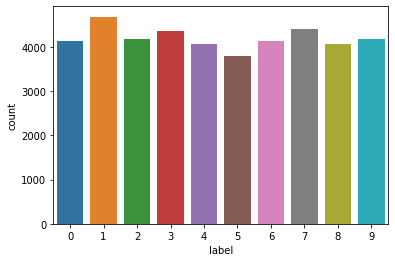

In [6]:
dst_train = Counter(train['label'])
print(dst_train)

# Plot distribution
sns.countplot(train['label'])

In [7]:
X = train.iloc[:, 1:]
y = train['label'].tolist() # target values

# Select 10000 rows data as a testing dataset
X_test = X.iloc[0:10000, :].values.astype('float32') # all pixel values 
y_test = y[0:10000] # Select label for testing data
X_train = X.iloc[10000:, :].values.astype('float32') # all pixel values 
y_train = y[10000:]

In [8]:
print((min(X_train[2]), max(X_train[2])))

# Normalizing the data, pixel intensities are currently between the range of 0 and 255
X_train = X_train/255.0
X_test = X_test/255.0

# Printing the shape of the Datasets
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

(0.0, 255.0)
X_train shape: (32000, 784)
32000 train samples
10000 test samples


We find the score of Decision Tree first, then Random Forest, and for both we will use both to predict where the label of the image is equal to '9'.

In [9]:
# use decision tree algorithm first

from sklearn import tree
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier()
parameters = {'max_features': ('auto', 'sqrt', 'log2'), 'max_depth':[1,100], 'min_samples_split':[2,100], 'min_samples_leaf': [1,100], 'min_weight_fraction_leaf': [0,0.5], 'random_state': [0,100], 'max_leaf_nodes':[0,100]}
clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train)
clf.score(X_train, y_train) * 100

69.78125

In [10]:
clf.best_params_

{'max_depth': 100,
 'max_features': 'auto',
 'max_leaf_nodes': 100,
 'min_samples_leaf': 1,
 'min_samples_split': 100,
 'min_weight_fraction_leaf': 0,
 'random_state': 0}

In [11]:
# Use with hypertuned parameters
dt = DecisionTreeClassifier(max_depth=100,max_features='auto',max_leaf_nodes=100,min_samples_leaf=1,min_samples_split=100,min_weight_fraction_leaf=0, random_state=0)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=100, max_features='auto', max_leaf_nodes=100,
                       min_samples_split=100, min_weight_fraction_leaf=0,
                       random_state=0)

In [12]:
# make prediction
y_predict = dt.predict(X_test)
dt.score(X_train, y_train) * 100

69.78125

In [13]:
# test prediction
print(y_predict[0:20])
print(y_test[0:20])
print(metrics.accuracy_score(y_test, y_predict) * 100)

[1 0 1 7 0 0 7 5 3 0 7 3 1 8 3 1 3 5 7 8]
[1, 0, 1, 4, 0, 0, 7, 3, 5, 3, 8, 9, 1, 3, 3, 1, 2, 0, 7, 5]
68.05


In [14]:
dt_score = cross_val_score(dt, X_train, y_train, scoring="neg_mean_squared_error",cv=1000)
dt_score_rmse = np.sqrt(-dt_score)
dt_score_rmse.mean()

2.1953578552890813

In [15]:
dt_score_rmse.std()

0.45414495177258524

In [16]:
cm= metrics.confusion_matrix(y_train,dt.predict(X_train))
cm

array([[2719,    6,   82,   60,    1,  114,   26,   58,   68,    7],
       [   1, 3169,  133,   34,   59,   47,   19,   90,   31,    6],
       [ 126,   97, 2081,  157,   67,   83,  104,  101,  293,   23],
       [  86,   53,  208, 2078,   25,  447,   65,  142,  172,   66],
       [  21,   33,   39,   29, 2019,   94,  115,  160,  126,  469],
       [ 160,   42,  120,  625,   66, 1439,  113,  104,  150,   70],
       [ 118,   51,  270,   68,   43,  184, 2110,   87,  194,    9],
       [  36,   38,   48,   23,   88,   91,   25, 2762,   29,  222],
       [  91,  137,  139,  309,   99,  209,  144,  123, 1717,  145],
       [  29,   19,   41,  128,   97,  142,   34,  314,  153, 2236]])

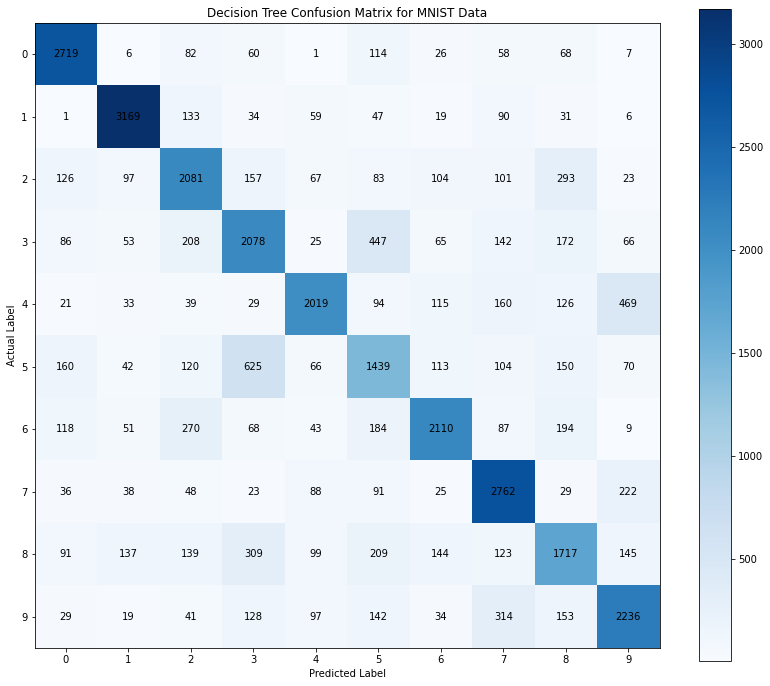

In [17]:
plt.figure(figsize=(14,12))
plt.imshow(cm,cmap=plt.cm.Blues)
plt.title("Decision Tree Confusion Matrix for MNIST Data")
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.colorbar()
width,height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]),xy=(y,x),horizontalalignment='center',verticalalignment='center')
plt.show()

In [18]:
y_predict = dt.predict(X_test)

# Actual and predicted classes
lst_actual_class = y_test
lst_predicted_class = y_predict

# Class = digit labels 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
lst_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 

# Compute multi-class confusion matrix
arr_out_matrix = multilabel_confusion_matrix(lst_actual_class, lst_predicted_class, labels=lst_classes)

# Temp store results
store_sens = [];
store_spec = [];
store_acc = [];
store_bal_acc = [];
store_prec = [];
store_fscore = [];
store_mcc = [];

# Loop for each target label
for no_class in range(len(lst_classes)):
    arr_data = arr_out_matrix[no_class];
    print("Predicted Performance of Digit Label/Class: {0}".format(no_class));

    tp = arr_data[1][1] # true positive
    fp = arr_data[0][1] # false positive
    tn = arr_data[0][0] # true negative
    fn = arr_data[1][0] # false negative

    sensitivity = round(tp/(tp+fn), 3);
    specificity = round(tn/(tn+fp), 3);
    accuracy = round((tp+tn)/(tp+fp+tn+fn), 3);
    balanced_accuracy = round((sensitivity+specificity)/2, 3);
    precision = round(tp/(tp + fp), 3)
    fscore = round((2 * ((precision * sensitivity) / (precision + sensitivity))), 3)
    mcc = round((((tp * tn)-(fp * fn))/ math.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))),3)
    
    store_sens.append(sensitivity);
    store_spec.append(specificity);
    store_acc.append(accuracy);
    store_bal_acc.append(balanced_accuracy);
    store_prec.append(precision);
    store_fscore.append(fscore);
    store_mcc.append(mcc);
    
    print("TP={0}, FP={1}, TN={2}, FN={3}".format(tp, fp, tn, fn));
    print("Sensitivity: {0}".format(sensitivity));
    print("Specificity: {0}".format(specificity));
    print("Accuracy: {0}".format(accuracy));
    print("Balanced Accuracy: {0}".format(balanced_accuracy));
    print("Precision: {0}".format(precision));
    print("F1-Score: {0}".format(fscore))
    print("MCC: {0}\n".format(mcc))

Predicted Performance of Digit Label/Class: 0
TP=855, FP=223, TN=8786, FN=136
Sensitivity: 0.863
Specificity: 0.975
Accuracy: 0.964
Balanced Accuracy: 0.919
Precision: 0.793
F1-Score: 0.827
MCC: 0.807

Predicted Performance of Digit Label/Class: 1
TP=972, FP=148, TN=8757, FN=123
Sensitivity: 0.888
Specificity: 0.983
Accuracy: 0.973
Balanced Accuracy: 0.936
Precision: 0.868
F1-Score: 0.878
MCC: 0.862

Predicted Performance of Digit Label/Class: 2
TP=665, FP=365, TN=8590, FN=380
Sensitivity: 0.636
Specificity: 0.959
Accuracy: 0.926
Balanced Accuracy: 0.798
Precision: 0.646
F1-Score: 0.641
MCC: 0.599

Predicted Performance of Digit Label/Class: 3
TP=630, FP=495, TN=8496, FN=379
Sensitivity: 0.624
Specificity: 0.945
Accuracy: 0.913
Balanced Accuracy: 0.784
Precision: 0.56
F1-Score: 0.59
MCC: 0.543

Predicted Performance of Digit Label/Class: 4
TP=595, FP=189, TN=8844, FN=372
Sensitivity: 0.615
Specificity: 0.979
Accuracy: 0.944
Balanced Accuracy: 0.797
Precision: 0.759
F1-Score: 0.679
MCC:

We see that for this subset of data with 10,000 rows, using the Decision Tree Classifier, for the '9' label we achieve an accuracy of 93.8 and precision of 68.2.

In [19]:
# use random forest algorithm next to compare to. Training time will be longer
parameters = {'max_features': ('auto', 'sqrt', 'log2'), 'max_depth':[1,100], 'min_samples_split':[2,100], 'min_samples_leaf': [1,100], 'min_weight_fraction_leaf': [0,0.5], 'random_state': [0,100], 'max_leaf_nodes':[0,100]}
model = RandomForestClassifier()
clf = GridSearchCV(model, parameters)
clf.fit(X_train, y_train)
clf.score(X_train, y_train) * 100

92.146875

In [20]:
clf.best_params_

{'max_depth': 100,
 'max_features': 'auto',
 'max_leaf_nodes': 100,
 'min_samples_leaf': 1,
 'min_samples_split': 100,
 'min_weight_fraction_leaf': 0,
 'random_state': 0}

In [21]:
# Use with hypertuned parameters
rf = RandomForestClassifier(max_depth=100,max_features='auto',min_samples_leaf=1,min_samples_split=100,min_weight_fraction_leaf=0, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, min_samples_split=100,
                       min_weight_fraction_leaf=0, random_state=0)

In [22]:
# make prediction
y_predict = rf.predict(X_test)
rf.score(X_train, y_train) * 100

95.971875

In [23]:
# test prediction
print(y_predict[0:20])
print(y_test[0:20])
print(metrics.accuracy_score(y_test, y_predict) * 100)

[1 0 1 4 0 0 7 3 5 3 8 9 1 3 3 1 8 0 7 8]
[1, 0, 1, 4, 0, 0, 7, 3, 5, 3, 8, 9, 1, 3, 3, 1, 2, 0, 7, 5]
93.89


In [24]:
cm= metrics.confusion_matrix(y_train,rf.predict(X_train))
cm

array([[3079,    0,    5,    0,    3,    7,   13,    0,   32,    2],
       [   0, 3520,   19,   11,    6,    8,    4,    5,   13,    3],
       [  11,    1, 3004,   18,   30,    3,   18,   20,   21,    6],
       [  11,    7,   55, 3131,    7,   29,    5,   31,   44,   22],
       [   6,    4,    8,    0, 3000,    1,   15,    7,   17,   47],
       [  20,    5,    3,   43,    5, 2753,   20,    1,   21,   18],
       [  19,    6,    3,    0,    5,   25, 3061,    0,   15,    0],
       [   3,   11,   44,    2,   17,    0,    0, 3212,   12,   61],
       [   7,   17,   15,   38,   13,   19,    8,    3, 2959,   34],
       [  16,    8,    9,   54,   39,    6,    2,   35,   32, 2992]])

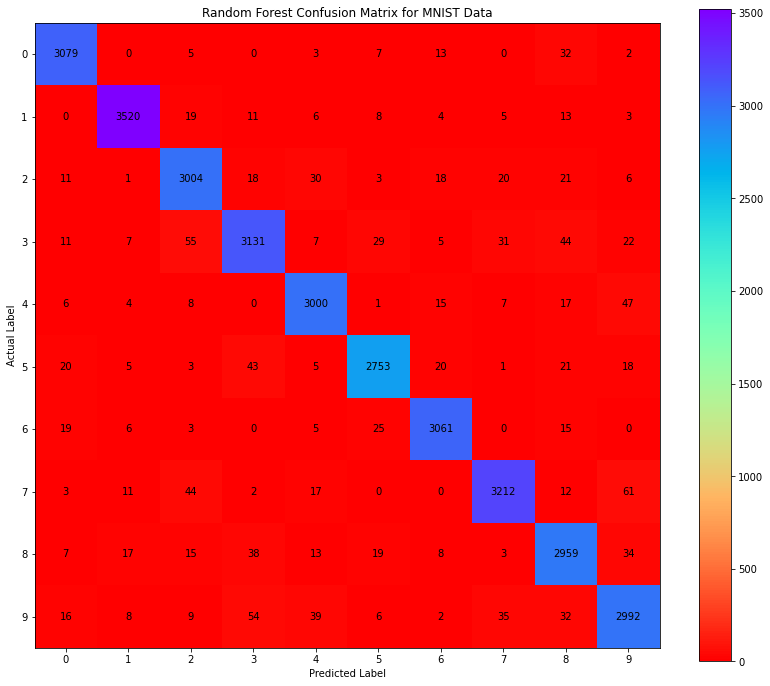

In [25]:
plt.figure(figsize=(14,12))
plt.imshow(cm,cmap='rainbow_r')
plt.title("Random Forest Confusion Matrix for MNIST Data")
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.colorbar()
width,height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]),xy=(y,x),horizontalalignment='center',verticalalignment='center')
plt.show()

Random Forest performed much better than Decision Tree Classifier; this is because it is not relying on feature importance from one decision tree, but utilizing multiple ones generally. Random Forest should be used especially due to the size of the dataset.

In [26]:
# Actual and predicted classes
lst_actual_class = y_test
lst_predicted_class = y_predict

# Class = digit labels 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
lst_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 

# Compute multi-class confusion matrix
arr_out_matrix = multilabel_confusion_matrix(lst_actual_class, lst_predicted_class, labels=lst_classes)

# Temp store results
store_sens = [];
store_spec = [];
store_acc = [];
store_bal_acc = [];
store_prec = [];
store_fscore = [];
store_mcc = [];

# Loop for each target label
for no_class in range(len(lst_classes)):
    arr_data = arr_out_matrix[no_class];
    print("Predicted Performance of Digit Label/Class: {0}".format(no_class));

    tp = arr_data[1][1] # true positive
    fp = arr_data[0][1] # false positive
    tn = arr_data[0][0] # true negative
    fn = arr_data[1][0] # false negative

    sensitivity = round(tp/(tp+fn), 3);
    specificity = round(tn/(tn+fp), 3);
    accuracy = round((tp+tn)/(tp+fp+tn+fn), 3);
    balanced_accuracy = round((sensitivity+specificity)/2, 3);
    precision = round(tp/(tp + fp), 3)
    fscore = round((2 * ((precision * sensitivity) / (precision + sensitivity))), 3)
    mcc = round((((tp * tn)-(fp * fn))/ math.sqrt((tp + fp)*(tp + fn)*(tn + fp)*(tn + fn))),3)
    
    store_sens.append(sensitivity);
    store_spec.append(specificity);
    store_acc.append(accuracy);
    store_bal_acc.append(balanced_accuracy);
    store_prec.append(precision);
    store_fscore.append(fscore);
    store_mcc.append(mcc);
    
    print("TP={0}, FP={1}, TN={2}, FN={3}".format(tp, fp, tn, fn));
    print("Sensitivity: {0}".format(sensitivity));
    print("Specificity: {0}".format(specificity));
    print("Accuracy: {0}".format(accuracy));
    print("Balanced Accuracy: {0}".format(balanced_accuracy));
    print("Precision: {0}".format(precision));
    print("F1-Score: {0}".format(fscore))
    print("MCC: {0}\n".format(mcc))

Predicted Performance of Digit Label/Class: 0
TP=965, FP=47, TN=8962, FN=26
Sensitivity: 0.974
Specificity: 0.995
Accuracy: 0.993
Balanced Accuracy: 0.984
Precision: 0.954
F1-Score: 0.964
MCC: 0.96

Predicted Performance of Digit Label/Class: 1
TP=1064, FP=28, TN=8877, FN=31
Sensitivity: 0.972
Specificity: 0.997
Accuracy: 0.994
Balanced Accuracy: 0.984
Precision: 0.974
F1-Score: 0.973
MCC: 0.97

Predicted Performance of Digit Label/Class: 2
TP=983, FP=73, TN=8882, FN=62
Sensitivity: 0.941
Specificity: 0.992
Accuracy: 0.986
Balanced Accuracy: 0.966
Precision: 0.931
F1-Score: 0.936
MCC: 0.928

Predicted Performance of Digit Label/Class: 3
TP=925, FP=73, TN=8918, FN=84
Sensitivity: 0.917
Specificity: 0.992
Accuracy: 0.984
Balanced Accuracy: 0.954
Precision: 0.927
F1-Score: 0.922
MCC: 0.913

Predicted Performance of Digit Label/Class: 4
TP=918, FP=63, TN=8970, FN=49
Sensitivity: 0.949
Specificity: 0.993
Accuracy: 0.989
Balanced Accuracy: 0.971
Precision: 0.936
F1-Score: 0.942
MCC: 0.936

P

We see that for this subset of data with 10,000 rows, using the Random Forest Classifier, for the '9' label we achieve an accuracy of 98.1 and precision of 90.2. Compared to Decision Tree, both score higher, especially the precision.

Decision Tree performed best on the following labels in order respectively: 
1, 7, 0, 9, 6, 2, 3, 4, 8, 5

Random Forest performed best on the following labels in order respectively: 
1, 7, 3, 0, 6, 2, 4, 9, 8, 5

Both classifiers did best on 1 & 7, and worst on 8 & 5. 

The label '9' was higher ranked in performance for Decision Tree, but Random Forest still had better performance with precision (TP/predicted yes) of 90.2 vs. 68.2 for Decision Tree.